In [1]:
import os
import time
import gc
from itertools import chain
import json
import pickle
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass, asdict
from typing import Tuple

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import cv2
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
from torchvision.utils import make_grid
from torchvision.transforms import Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image, center_crop
from kornia.geometry.transform import resize, warp_affine, get_affine_matrix2d
import kornia

from diffusers import UNet2DModel, DDIMScheduler, get_cosine_schedule_with_warmup

import wandb

In [2]:
class Dataset():
    def __init__(self, imgs, embs, track):
        self.imgs = imgs
        self.embs = embs
        self.track = track
        
        self.mean = imgs.mean(dim=(0, 2, 3))
        # self.std = imgs.std(dim=(0, 2, 3))
        # actual std is around .1 but this works much better
        self.std = torch.full((3,), .5)
        self.frame_count = imgs.shape[0]
        
        self.norm = Normalize(self.mean, self.std)
        self.denorm = Normalize(-self.mean / self.std, 1 / self.std)
        
        self.imgs = self.norm(self.imgs)
    
    def sample(self, start_frames, num_frames=None):
        """
        Sample dataset at given start frames
        Returns: [imgs, embs, track]
        """
        if num_frames is None:
            num_frames = 1
        frames = [
            [
                getattr(self, prop)[start_frames + i].to('cuda').clone()
                for i in range(num_frames)
            ] for prop in ['imgs', 'embs', 'track']
        ]
        return [torch.stack(v, dim=1) for v in frames]
    
    def tensor_to_img(self, x):
        return Image.fromarray(
            self.denorm(x).clip(0, 1).movedim(-3, -1).detach().cpu()
            .multiply(255).type(torch.uint8).numpy()
        )

In [3]:
def process_dataset():
    # load tracking (generated from 910x512 frames)
    with open('datasets/track-rotifer.json', 'r') as f:
        track_json = json.load(f)
        # body (x, y normalized so [0, 1] is sample bounds),
        # head direction (angle in radians),
        # and cam pos (x, y same scale as body, total offst from first frame)
        body = torch.tensor(track_json['body'])
        track = torch.empty(body.shape[0], 5)
        head = torch.tensor(track_json['head'])
        head_offset = head - body
        track[:, :2] = (body - torch.tensor([[0, 0]])) / 512
        track[:, 2] = torch.atan2(head_offset[:, 1], head_offset[:, 0])

        world = (torch.tensor(track_json['world']) - torch.tensor([[0, 0]])) / 512
        world_diff = torch.cat([torch.tensor([[0, 0]]), world.diff(dim=0)], dim=0)
        for jump in track_json['jumps']:
            if jump > 0:
                world_diff[jump] = world_diff[jump - 1]

        track[:, 3:5] = -world_diff.cumsum(dim=0)
    
    # cap = cv2.VideoCapture(cf.dataset_vid_path)
    # vid_w, vid_h = (
    #     cap.get(cv2.CAP_PROP_FRAME_WIDTH),
    #     cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    # )
    vid_w, vid_h = 512, 512
    ci, cj = torch.meshgrid(
        *[torch.arange(64 * 2) for _ in range(2)], 
        indexing='xy'
    )
    coords = torch.stack([ci, cj], dim=0)
    # storing all takes about 3.3 GB
    imgs = []
    embs = []
    
    for i in range(1):        
        # success, img = cap.read()
        # if not success or i == 100:
        #     print(f'failed on {i}')
        #     break
        img = cv2.imread('datasets/0.jpg')
        
        # crop and resize image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = to_tensor(img)
        # try to center subject in frame before cropping
        # max_track = (vid_w - vid_h) // 2
        # track_body_x = ((track[i, 0] - .5) * vid_h).clip(-max_track, max_track).item()
        # affine_mat = get_affine_matrix2d(
        #     translations=torch.tensor([[round(-track_body_x), 0]]),
        #     center=torch.zeros(1, 2), scale=torch.ones(1, 2),
        #     angle=torch.zeros(1))[:, :2]
        # img = warp_affine(img[None], affine_mat, img.shape[-2:])[0]
        # tbx_normed = round(track_body_x) / vid_h
        # track[i, 0] -= tbx_normed # body
        # track[i, 3] += tbx_normed # cam
        img = center_crop(img, vid_h)
        img = to_pil_image(img)
        # will train on random crops up to 2x scale
        img.thumbnail((64 * 2,) * 2, Image.LANCZOS)
        imgs.append(to_tensor(img))
        
        # generate localizing embedding image
        # body -> pixel
        dirs = coords - track[i, :2, None, None] * (64 * 2)
        angles = torch.atan2(dirs[1], dirs[0])
        angles = angles - track[i, 2]
        local_dx = angles.cos()
        local_dy = angles.sin()
        dist = (dirs[0]**2 + dirs[1]**2).sqrt() * (2 / 64)
        local_embedding = torch.stack([
            local_dx, local_dy, 1 - dist
        ], dim=0)
        embs.append(local_embedding)
    
    imgs = torch.stack(imgs)
    embs = torch.stack(embs)
    return Dataset(imgs, embs, track)

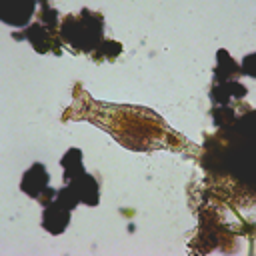

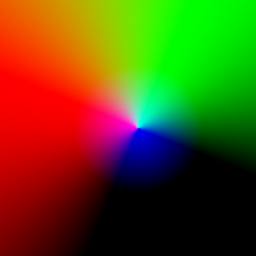

In [10]:
ds = process_dataset()
display.display(ds.tensor_to_img(ds.imgs[0]).resize((256, 256)))
plt.show()
display.display(to_pil_image(ds.embs[0].clip(0, 1)).resize((256, 256)))